# 프로젝트: 뉴스기사 요약해보기  

목표 : 새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져보자.

## Step 1. 데이터 수집하기  
데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용
sunnysai12345/News_Summary  https://github.com/sunnysai12345/News_Summary

데이터 세트는 4515 개의 예제로 구성되며 Author_name, Headlines, Url of Article, Short text, Complete Article을 포함한다. Inshorts에서 요약 된 뉴스를 수집하고 힌두교, 인도 시대 및 Guardian의 뉴스 기사 만 긁어 낸 것입니다. 기간은 2 월부터 2017 년 8 월까지이다.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac6/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
94616,BCCI members to question Ã¢ÂÂ¹1 cr reward for...,The BCCI is set to review the unauthorised pay...
41418,Over 14L Class 10 students won't give retest: ...,Responding to the uproar over CBSE's decision ...
46461,Russian hooligan arrested for homicide attempt...,German police have stated that they have arres...
618,Over 200 hotels end agreement with OYO over di...,The Federation of Hotel and Restaurant Associa...
62536,Gujarat CM Vijay Rupani calls Rahul Gandhi 'ga...,Gujarat Chief Minister Vijay Rupani on Sunday ...
93914,Harbhajan among ICC's 8 ambassadors for Champi...,Indian spinner Harbhajan Singh is among the ei...
40477,DGCA gave us clean chit in February '17: AirAs...,AirAsia India has said that allegations regard...
20456,Idris Elba denies he's playing James Bond afte...,Idris Elba has denied that he will be playing ...
67466,"Varun, Anushka pay tribute to Mahatma on Gandh...","Varun Dhawan and Anushka Sharma, who will star..."
22989,"N Korea still pursuing nuclear, missile progra...",North Korea is still pursuing its nuclear and ...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다. 추출적 요약을 하는 경우에는 오직 text열만을 사용하면 된다.

## Step 2. 데이터 전처리하기 (추상적 요약)  
실습에서 사용된 전처리를 참고하고, 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제한다.  
불용어 제거는 상대적으로 길이가 짧은 요약 데이터에 사용하는 것이 좋을까 고민하기.

### 2.1 데이터 정리하기

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
#유일한 샘플 수 조회
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
#중복 샘플을 제거
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [7]:
#Null 값 갯수 조회
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
#데이터프레임에서 Null을 제거
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


#### 텍스트 정규화와 불용어 제거


In [10]:
#텍스트 정규화를 위한 사전(dictionary)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [11]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [13]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [55]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [56]:
data.isnull().sum()

headlines         0
text              0
decoder_input     0
decoder_target    0
dtype: int64

In [57]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


### 2-2. 훈련데이터와 테스트데이터 나누기
#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


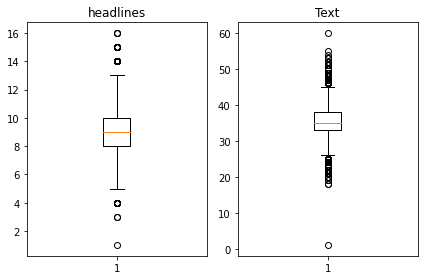

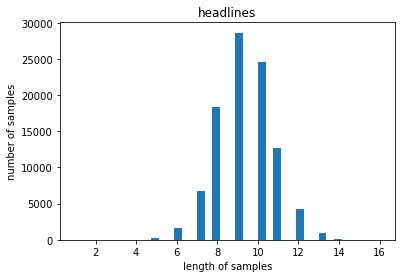

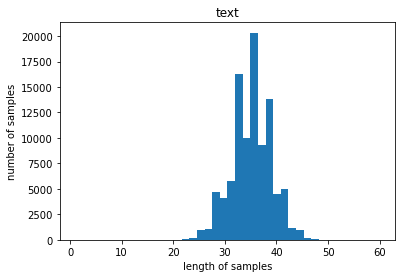

In [59]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서 부터 차례대로 그래프는 각각 요약과 실제 텍스트의 길이 분포, 요약본 샘플 길이별 갯수, 실제 텍스트 샘플 길이별 갯수를 나타내고 있어요.
Text의 경우 최소 길이가 1, 최대 길이가 60으로 그 차이가 커요. 하지만 평균 길이는 35로 시각화 된 그래프로 봤을 때는 대체적으로는 40 내외의 길이를 가진다는 것을 확인할 수 있어요.

headlines 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있네요.

이로부터 Text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼게요.

In [26]:
text_max_len = 45
headlines_max_len = 13

In [27]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [28]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


#### 시작 토큰과 종료 토큰 추가하기

In [29]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [30]:
#Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [32]:
#encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들고, 섞기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 1740 16411 31537 ... 92596  5241 97718]


In [33]:
#데이터 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [34]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19672


In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 2-3. 정수 인코딩  
#### 단어 집합(vocaburary) 만들기 및 정수 인코딩

In [42]:
def tokenizer_threshold(v_threshold, v_tokenizer):
    threshold = v_threshold # 8
    total_cnt = len(v_tokenizer.word_index) # 단어의 수 (v_tokenizer.word_index : {단어 : 단어빈도수가 많은거 순})
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in v_tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

**1) encoder_input_train**

In [43]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [44]:
tokenizer_threshold(8, src_tokenizer)

단어 집합(vocabulary)의 크기 : 69424
등장 빈도가 7번 이하인 희귀 단어의 수: 48778
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20646
단어 집합에서 희귀 단어의 비율: 70.26100483982485
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8611618613393115


In [45]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [46]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[15343, 100, 1211, 2099, 3738, 297, 1132, 530, 10271, 304, 1132, 31, 1303, 2285, 1281, 1828, 2804, 19407, 60, 3, 13, 390, 12, 1935, 297, 1132, 7, 31, 4099, 2804, 174, 10271, 304, 1132, 2211, 274, 77, 132, 12, 3878, 2103, 4099], [201, 49, 3396, 116, 57, 66, 1030, 184, 1399, 39, 934, 2584, 4255, 1648, 4158, 116, 4, 4255, 40, 2761, 444, 860, 731, 116, 66, 2761, 4100, 1019, 955, 6473], [18384, 5, 34, 13372, 290, 249, 7, 1166, 1953, 4285, 521, 1736, 3964, 2655, 368, 7070, 1185, 4122, 242, 26, 17, 3, 531, 2348, 84, 145, 3685, 436, 25, 1422, 3042, 9839, 2519, 224, 912]]


**2) decoder_input_train**

In [47]:
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train)

In [48]:
tokenizer_threshold(6, tar_tokenizer)

단어 집합(vocabulary)의 크기 : 30088
등장 빈도가 5번 이하인 희귀 단어의 수: 19659
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10429
단어 집합에서 희귀 단어의 비율: 65.33834086679074
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.640924878313602


In [49]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1220, 5203, 551, 1870, 5, 1479, 2245, 282, 43, 1871], [1, 86, 22, 89, 786, 2201, 14, 864, 4, 1271, 6828], [1, 2202, 81, 3784, 2014, 2568, 38, 1978, 99], [1, 50, 2100, 150, 83, 5, 2355, 1872, 410, 6829], [1, 50, 2143, 110, 327, 29, 537, 655, 261, 837]]
target
decoder  [[1220, 5203, 551, 1870, 5, 1479, 2245, 282, 43, 1871, 2], [86, 22, 89, 786, 2201, 14, 864, 4, 1271, 6828, 2], [2202, 81, 3784, 2014, 2568, 38, 1978, 99, 2], [50, 2100, 150, 83, 5, 2355, 1872, 410, 6829, 2], [50, 2143, 110, 327, 29, 537, 655, 261, 837, 2]]


In [50]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))



삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [51]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


**3) 패딩하기**

In [52]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)  
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있다. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보기.

In [53]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256


### 모델 설계하기 

In [54]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [60]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,)) # text_max_len : 45
 
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) # src_vocab : 20000, 

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4) #recurrent_dropout=0
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4) #recurrent_dropout=0
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4) #recurrent_dropout=0
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2) #recurrent_dropout=0
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) 

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [61]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 113s 368ms/step - loss: 5.2320 - val_loss: 4.8324
Epoch 2/50
308/308 [==============================] - 115s 373ms/step - loss: 4.6811 - val_loss: 4.4672
Epoch 3/50
308/308 [==============================] - 115s 374ms/step - loss: 4.3568 - val_loss: 4.2171
Epoch 4/50
308/308 [==============================] - 119s 388ms/step - loss: 4.1059 - val_loss: 4.0376
Epoch 5/50
308/308 [==============================] - 120s 391ms/step - loss: 3.9069 - val_loss: 3.8861
Epoch 6/50
308/308 [==============================] - 123s 399ms/step - loss: 3.7430 - val_loss: 3.7965
Epoch 7/50
308/308 [==============================] - 120s 391ms/step - loss: 3.6089 - val_loss: 3.6942
Epoch 8/50
308/308 [==============================] - 120s 391ms/step - loss: 3.4909 - val_loss: 3.6335
Epoch 9/50
308/308 [==============================] - 117s 381ms/step - loss: 3.3914 - val_loss: 3.5763
Epoch 10/50
308/308 [==============================] - 117s 380m

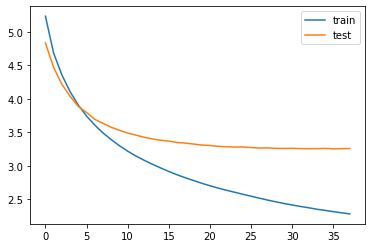

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비  

In [64]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [65]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계

In [66]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들기

In [71]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [68]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)  
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보기 

In [114]:
for i in range(50, 100):
    print(f"원문{i} :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문50 : allegedly smashed wife head hammer slit four year old son neck electric cutter district haryana sunday following tried committing suicide overpowered villagers took police station reportedly often wife suspected later arrested 
실제 요약 : haryana man murders wife slits year old son neck 
예측 요약 :  wife of wife smashes his son in noida


원문51 : jacqueline fernandez said decided wants performer age six honestly quite afraid bring parents since quite unconventional career added jacqueline said never films pure joy comes entertainer 
실제 요약 : decided want to be when was jacqueline 
예측 요약 :  am happy to work with age of age of age jacqueline jacqueline


원문52 : facebook working feature called time facebook track much time users spend average app also offer users option set daily time limit reduce app usage company spokesperson confirmed reveal feature would launched 
실제 요약 : facebook working on tool to track users time spent on app 
예측 요약 :  facebook to let users share time to share spent

예측 요약 :  india has woman who lost over lakh in last months


원문74 : ayushmann khurrana wife tahira kashyap revealed metoo moment adding found years shared husband parents added started dating ayushmann cried every step physical proximity scared physical touch ayushmann love patience tahira wrote 
실제 요약 : had my metoo moment years ago ayushmann love me wife 
예측 요약 :  have been been in ayushmann wife ayushmann wife


원문75 : rohit sharma led india victory recently concluded asia cup took twitter share picture indian team celebrating trophy asia cup one player entire unit field special game special win wrote 
실제 요약 : asia cup was not just about player stand in captain rohit sharma 
예측 요약 :  rohit sharma posts indian cup final of asia cup final


원문76 : grace meng wife former interpol president meng hongwei detained china said sure husband alive calling chinese authorities cruel dirty grace added husband victim political persecution hongwei investigation china suspected bribery 
실제 요약 : ex 

예측 요약 :  bjp files complaint against kejriwal over kejriwal in delhi


원문97 : filing application marry british partner coutinho iron lady sharmila said want return home state manipur fought armed forces special powers act long years people rejected polls want go back said 
실제 요약 : people rejected me do not want to return to manipur 
예측 요약 :  couple offers to marry girlfriend in telangana


원문98 : bjp candidates rajya sabha elections uttar pradesh cm yogi adityanath announced friday two thirds majority assembly party required number mlas win seats bjp candidate anil agarwal defeated bsp candidate br ambedkar win ninth seat sp candidate jaya bachchan tenth seat 
실제 요약 : all bjp candidates won rajya sabha polls from up cm yogi 
예측 요약 :  yogi to contest rajya sabha polls in up in guj


원문99 : supreme court wednesday allowed woman terminate pregnancy based medical report said week old foetus without skull would able survive report suggested allowing pregnancy run full course could pose seve

In [115]:
seq2text(encoder_input_test[52])

'facebook working feature called time facebook track much time users spend average app also offer users option set daily time limit reduce app usage company spokesperson confirmed reveal feature would launched '

In [127]:
str_test = seq2summary(decoder_input_test[52])[:-1]
str_test

'facebook working on tool to track users time spent on app'

## Step 5. Summa을 이용해서 추출적 요약해보기  
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.

Summa의 summarize를 사용하여 추출적 요약을 해보기.

In [134]:
data[data['headlines'] == str_test].index

Int64Index([36928], dtype='int64')

In [77]:
import requests
from summa.summarizer import summarize

In [140]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [141]:
print('Summary:')
print(summarize(summa_data.iloc[36928].text, words=13))

Summary:
Facebook is working on a feature called 'Your Time on Facebook' which will track how much time users spend on an average on the app.


### 추상적 요약과 추출적 요약 비교

In [148]:
print("1)원문(전처리전) :", summa_data.iloc[36928].text)
print("\n")
print("2)원문(전처리후) :", seq2text(encoder_input_test[52]))
print("\n")
print("3)실제 요약 :", seq2summary(decoder_input_test[52]))
print("\n")
print("4)추상적 요약 :", decode_sequence(encoder_input_test[52].reshape(1, text_max_len)))
print("\n")
print("5)추출적 요약 :", summarize(summa_data.iloc[36928].text, ratio=0.5))
print("\n")

1)원문(전처리전) : Facebook is working on a feature called 'Your Time on Facebook' which will track how much time users spend on an average on the app. It will also offer users an option to set a daily time limit to reduce app usage. A company spokesperson confirmed the same but did not reveal when or if the feature would be launched.


2)원문(전처리후) : facebook working feature called time facebook track much time users spend average app also offer users option set daily time limit reduce app usage company spokesperson confirmed reveal feature would launched 


3)실제 요약 : facebook working on tool to track users time spent on app 


4)추상적 요약 :  facebook to let users share time to share spent on app


5)추출적 요약 : Facebook is working on a feature called 'Your Time on Facebook' which will track how much time users spend on an average on the app.




## 느낀점
추상적 요약은 얼추 실제 요약한 의미와 비슷하게 요약을 이루어 냈다.  
어텐션에 대한 개념을 아직 정확히 숙지하지 못했지만 의미있는 프로젝트를 한거 같다.   
네이버에 뉴스 요약봇이 있다는 것을 이 노드를 통해서 알았다. 네이버에 너무 관심이 없었나보다. AI연구도 많이 한다는데 관심을 가져야겠다.   
프로젝트 진행중 추출적 요약이 잘 되지 않았다. 문장이 짧아서인지 ration=0.5 이하나 words=13 이하로 파라미터 설정시 데이터가 요약되지 않았다.  
전처리를 하게 되면 더더욱 데이터는 나오지 않았다. 추출적 요약은 전처리 되지 않은 원문으로 처리했다.   
확실히 추상적 요약이 내용을 summary한 느낌을 준다.   


